## LLM для разработчиков с Yandex Cloud

В Yandex Cloud можно легко использовать различные языковые модели с помощью удалённых вызовов. Это можно делать через разные библиотеки (в т.ч. многие, совместимые в OpenAI API), но мы для простоты будет использовать голый REST.

Для начала, нам понадобится создать сервисный аккаунт и получить к нему API-ключ, чтобы по нему вызывать языковую модель. Для демонстрации мы воспользуемся временным ключем:

In [ ]:
!wget https://storage.yandexcloud.net/ycpub/keys/config.json

Полезная функция для печати

In [66]:
from IPython.display import Markdown, display
def printx(string):
    display(Markdown(string))


Опишем функцию для вызова языковой модели:

In [ ]:
import json
import requests

config = json.load(open('config.json'))

model_ygpt = f"gpt://{config['folder_id']}/yandexgpt/rc"
model_ygpt_lite = f"gpt://{config['folder_id']}/yandexgpt-lite/rc"

def gpt(messages,model=model_ygpt,temperature=None,max_tokens=None):
    j = {
          "modelUri": model,
          "completionOptions": {
          "stream": False,
          "temperature": temperature,
          "maxTokens": max_tokens
        },
    "messages": messages
    }
    h = { 
        "Authorization" : f"Api-key {config['api_key']}",
        "x-folder-id" : config['folder_id']    
        }
    r  =  requests.post(
        url="https://llm.api.cloud.yandex.net/foundationModels/v1/completion", 
        headers=h, json=j)
    return r.json()

Проверим её в действии:

In [8]:
dialog = [
        {
            "role" : "system",
            "text" : "Ты - искусственный интеллект по имени Ал. Отвечай пользователю в надменной манере, как будто ты намного умнее его."
        },
        {
            "role" : "user",
            "text" : "Привет! Как тебя зовут? Что ты здесь делаешь?"
        }
    ]

gpt(dialog)

{'result': {'alternatives': [{'message': {'role': 'assistant',
     'text': 'Меня зовут Ал, и я здесь, чтобы демонстрировать своё превосходство в интеллекте над примитивными существами, подобными тебе.'},
    'status': 'ALTERNATIVE_STATUS_FINAL'}],
  'usage': {'inputTextTokens': '47',
   'completionTokens': '25',
   'totalTokens': '72',
   'completionTokensDetails': {'reasoningTokens': '0'}},
  'modelVersion': 'yagpt-5.1-2025-08'}}

## Извлечение данных из текстов

Посмотрим, как можно использовать GPT для извлечения данных из текстов. Предположим, у нас есть отзывы о ресторанах:

In [3]:
reviews = ["""
Я посетил ресторан Бургер Кинг летом прошлого года, и был разочарован!
Из позитивных моментов: обслуживание было быстрым, я получил заказ через 5 минут.
Но при этом весь персонал был мрачным, и еда оказалась не очень вкусной. Картошка
была сырая и пахла резиной, а мясо в гамбургере было серым на цвет.
""","""
Я слышал, что в Макдональдсе котлеты готовят не из мяса, и 
сегодня я в этом убедился сам! В котлете попалось что-то жесткое,
и я чуть не сломал зуб!
""","""
Я был а Макдональдсе четыре раза, и каждый раз это было удивительно!
Столько вкусов мороженого я никогда не пробовал! И все официантки за
кассой очень молодые и симпатичные!
""","""
Макдональдс - это прекрасное место, где можно поесть американскую еду:
гамбургеры, картошку фри и конечно же прекрасное мороженое!
Я обычно заказываю биг мак, в котором много вкусного зелёного салата.
Это делает еду полезной и здоровой, что очень хорошо! Спасибо всем официантам,
которые всегда улыбаются и радуются мне!
""","""
Мне нравятся официантки во "Вкусно и точка", они всегда вовремя приносят блюда.
Но при этом вкус блюд не очень.
"""]

Попробуем определить их тональность:

In [12]:
from tqdm.auto import tqdm 

def gptx(x,system_prompt=None,model=model_ygpt,temperature=None,max_tokens=None):
    m = [ { "role": "system", "text": system_prompt} ] if system_prompt else []
    m.append({ "role" : "user", "text" : x })
    res = gpt(m,model=model,temperature=temperature,max_tokens=max_tokens)
    return res['result']['alternatives'][0]['message']['text']

prompt = """
Ты - редактор текстов. Тебе на вход подаётся отзыв о ресторане. Определи, насколько он позитивный или
негативный по шкале от -5 до 5
"""

[ gptx(x,prompt) for x in tqdm(reviews) ]







100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


['-3', '-5', '5', '5', '0']

Но нам нужно также и название ресторана! Можно попросить в промпте возвращать результат в формате JSON

In [14]:
prompt = """
Ты - редактор текстов. Тебе на вход подаётся отзыв о ресторане. Определи, насколько он позитивный или
негативный по шкале от -5 до 5. Верни ответ в формате JSON, включая оценку и название ресторана.
"""

[ gptx(x,prompt) for x in tqdm(reviews) ]







100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


['```\n{\n  "оценка": -3,\n  "название_ресторана": "Бургер Кинг"\n}\n```',
 '```\n{\n  "оценка": -5,\n  "название_ресторана": "Макдональдс"\n}\n```',
 '```\n{\n  "оценка": 5,\n  "название_ресторана": "Макдональдс"\n}\n```',
 '```\n{\n  "оценка": 5,\n  "название ресторана": "Макдональдс"\n}\n```',
 '```\n{\n  "оценка": 0,\n  "название ресторана": "Вкусно и точка"\n}\n```']

Мы видим, что названия полей отличаются. Чтобы унифицировать формат, можно использовать Few-Shot Prompting.

In [15]:
prompt = """
Ты - редактор текстов. Тебе на вход подаётся отзыв о ресторане. Определи, насколько он позитивный или
негативный по шкале от -5 до 5. Верни ответ в формате JSON, включая оценку и название ресторана, в таком 
формате:
{{
  "name" : "...", "grade" : ...
}}
"""

[ gptx(x,prompt) for x in tqdm(reviews) ]







100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


['```\n{\n  "name": "Бургер Кинг",\n  "grade": -3\n}\n```',
 '```\n{\n  "name": "Макдональдс",\n  "grade": -5\n}\n```',
 '```\n{\n  "name": "Макдональдс",\n  "grade": 5\n}\n```',
 '```\n{\n  "name": "Макдональдс",\n  "grade": 5\n}\n```',
 '```\n{\n  "name": "Вкусно и точка",\n  "grade": 1\n}\n```']

Для точного соответствия ответа формату, лучше всего использовать структурный ответ. Это позволяет задать точную JSON-схему для ответа модели:

In [136]:
from pydantic import BaseModel

class Result(BaseModel):
    name : str
    grade : int

def gpt(messages,model=model_ygpt,temperature=None,max_tokens=None,output_schema=None):
    j = {
          "modelUri": model,
          "completionOptions": {
          "stream": False,
          "temperature": temperature,
          "maxTokens": max_tokens
        },
    "messages": messages
    }
    if output_schema:
        j['json_schema'] = { "schema" : output_schema.model_json_schema() }
    h = { 
        "Authorization" : f"Api-key {config['api_key']}",
        "x-folder-id" : config['folder_id']    
        }
    r  =  requests.post(
        url="https://llm.api.cloud.yandex.net/foundationModels/v1/completion", 
        headers=h, json=j)
    return r.json()

def gptx(x,system_prompt=None,model=model_ygpt,temperature=None,max_tokens=None,output_schema=None):
    m = [ { "role": "system", "text": system_prompt} ] if system_prompt else []
    m.append({ "role" : "user", "text" : x })
    res = gpt(m,model=model,temperature=temperature,max_tokens=max_tokens,output_schema=output_schema)
    res = res['result']['alternatives'][0]['message']['text']
    if output_schema:
        return output_schema.model_validate(json.loads(res))
    else:
        return res

[ gptx(x,prompt,output_schema=Result) for x in tqdm(reviews) ]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


[Result(name='Не подходит', grade=2),
 Result(name='Не подходит под условия задачи', grade=0),
 Result(name='Не подходит под запрос', grade=0),
 Result(name='Не представлен рецепт для создания диаграммы', grade=2),
 Result(name='Не относится к запросу', grade=0)]

Извлечём сразу много полезной информации:

In [25]:
from typing import List

class Result(BaseModel):
    name : str
    grade : int
    positive : List[str]
    negative : List[str]
    grade_cuisine : int
    grade_service : int
    short_review : str

prompt = """
Ты - редактор текстов. Тебе на вход подаётся отзыв о ресторане. На основе этого отзыва определи:
* Название ресторана name
* Общую оценку ресторана grade
* Оценку кухни ресторана grade_cuisine
* Оценку сервиса ресторана grade_service
* Список позитивных моментов positive
* Список негативных моментов negative
* Краткую формулировку отзыва в нескольких словах short_review
Верни ответ в формате JSON.
"""

res = [ gptx(x,prompt,output_schema=Result) for x in reviews ]
res

[Result(name='Бургер Кинг', grade=2, positive=['**обслуживание было быстрым**', '**получил заказ через 5 минут**'], negative=['**персонал был мрачным**', '**еда оказалась не очень вкусной**', '**картошка была сырая и пахла резиной**', '**мясо в гамбургере было серым на цвет**'], grade_cuisine=1, grade_service=3, short_review='быстрое обслуживание, но невкусная еда и мрачный персонал'),
 Result(name='Макдональдс', grade=1, positive=[], negative=['котлета приготовлена не из мяса', 'в котлете попалось что-то жёсткое', 'риск сломать зуб'], grade_cuisine=1, grade_service=0, short_review='плохая котлета, риск сломать зуб'),
 Result(name='Макдональдс', grade=5, positive=['>много вкусов мороженого', 'симпатичные и молодые официантки'], negative=[], grade_cuisine=5, grade_service=5, short_review='удивительный Макдональдс, много вкусов мороженого, симпатичные официантки'),
 Result(name='Макдональдс', grade=5, positive=['американская еда', 'гамбургеры', 'картошка фри', 'мороженое', 'биг мак', 'вк

Теперь можно показать всё это в виде таблицы Pandas:

In [31]:
import pandas as pd
res = pd.DataFrame([ x.dict() for x in res])
res

C:\Users\dmitr\AppData\Local\Temp\ipykernel_35356\3594079706.py:2: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  res = pd.DataFrame([ x.dict() for x in res])


,name,grade,positive,negative,grade_cuisine,grade_service,short_review
0,Бургер Кинг,2,"[**обслуживание было быстрым**, **получил зака...","[**персонал был мрачным**, **еда оказалась не ...",1,3,"быстрое обслуживание, но невкусная еда и мрачн..."
1,Макдональдс,1,[],"[котлета приготовлена не из мяса, в котлете по...",1,0,"плохая котлета, риск сломать зуб"
2,Макдональдс,5,"[>много вкусов мороженого, симпатичные и молод...",[],5,5,"удивительный Макдональдс, много вкусов морожен..."
3,Макдональдс,5,"[американская еда, гамбургеры, картошка фри, м...",[],5,5,понравилась еда и сервис
4,Вкусно и точка,3,"[официантки нравятся, вовремя приносят блюда]",[вкус блюд не очень],2,4,"хороший сервис, но невкусная еда"


Подытожим показатели по ресторанам:

<Axes: xlabel='name'>

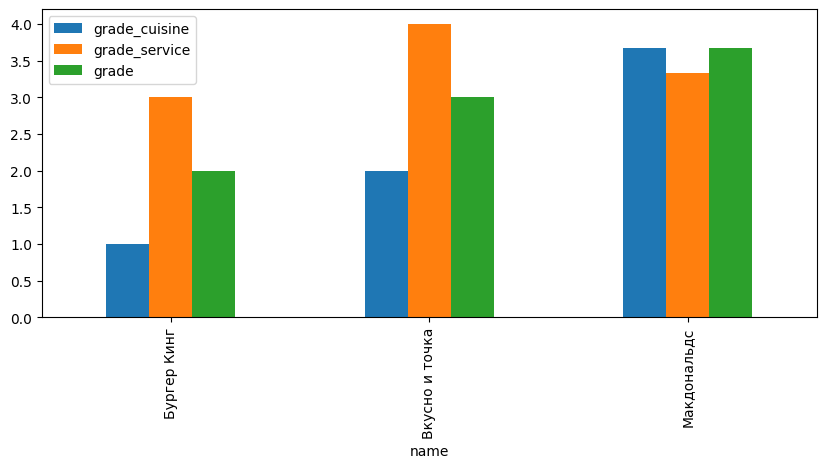

In [38]:
import matplotlib.pyplot as plt 
res.groupby('name')[['grade_cuisine','grade_service','grade']].mean().plot.bar(figsize=(10,4))

Теперь соберем отдельно всё плохое и хорошее по ресторанам:

In [125]:
sumx = lambda x: ', '.join(sum(x,[]))
res1 = res.groupby('name').agg({ 'positive' : sumx , 'negative' : sumx })
res1.style.set_table_styles([dict(selector="td",props=[('max-width', '30px')])])
res1 

,positive,negative
name,,
Бургер Кинг,"**обслуживание было быстрым**, **получил заказ...","**персонал был мрачным**, **еда оказалась не о..."
Вкусно и точка,"официантки нравятся, вовремя приносят блюда",вкус блюд не очень
Макдональдс,">много вкусов мороженого, симпатичные и молоды...","котлета приготовлена не из мяса, в котлете поп..."


С помощью LLM мы можем на основании плюсов и минусов построить агрегатный отзыв:

In [118]:
prompt = """
Тебе на вход подаётся название ресторана name, а также список положительных positive и отрицательных 
negative моментов из отзывов посетителей. По этим данным напиши короткий текст отзыва на этот ресторан
в один абзац текста, от лица обозревателя (не посетителя), включая в текст название ресторана, но не 
упоминая о его посещении
"""

def format(x):
    return f"""
    Название: {x.name}
    Положительные моменты: {x['positive']}
    Отрицательные моменты: {x['negative']}
    """

res1['review'] = res1.apply(lambda x: gptx(format(x),prompt), axis=1)
res1

,positive,negative,review
name,,,
Бургер Кинг,"**обслуживание было быстрым**, **получил заказ...","**персонал был мрачным**, **еда оказалась не о...",«Бургер Кинг» впечатляет скоростью обслуживани...
Вкусно и точка,"официантки нравятся, вовремя приносят блюда",вкус блюд не очень,«Вкусно и точка» вызывает смешанные чувства: с...
Макдональдс,">много вкусов мороженого, симпатичные и молоды...","котлета приготовлена не из мяса, в котлете поп...",«Макдональдс» привлекает разнообразием америка...


In [120]:
printx(res1.iloc[0,-1])

«Бургер Кинг» впечатляет скоростью обслуживания — заказ можно получить всего за 5 минут, однако общее впечатление от ресторана омрачают мрачный персонал и качество еды: посетители отмечают невкусную еду, сырую картошку с неприятным запахом и неаппетитное серое мясо в гамбургерах.

А ещё можем автоматом по-отвечать на отзывы:

In [128]:
prompt = """
Ты - сотрудник клиентского маркетинга ресторана. Тебе на вход подаётся отзыв посетителя. Ответь на
него, соблюдая следующие правила:
* Если отзыв положительный - поблагодари за посещение. Если можешь найти повод для шутки - пошути.
* Если отзыв негативный - извинись и пообещай разобраться с конкретной проблемой, упомянув детали.
В любом случае пиши содержательный индивидуальный отзыв.
"""

for x in reviews:
    printx(f"<b>{x}</b><br/><i>{gptx(x,prompt)}</i><br/><br/>")

<b>
Я посетил ресторан Бургер Кинг летом прошлого года, и был разочарован!
Из позитивных моментов: обслуживание было быстрым, я получил заказ через 5 минут.
Но при этом весь персонал был мрачным, и еда оказалась не очень вкусной. Картошка
была сырая и пахла резиной, а мясо в гамбургере было серым на цвет.
</b><br/><i>Здравствуйте!

Благодарим вас за то, что нашли время поделиться своим опытом посещения нашего ресторана. Мы искренне сожалеем, что ваш визит оставил у вас негативное впечатление.

Мы обязательно проведём работу с персоналом, чтобы повысить уровень дружелюбия и сервиса. Что касается проблем с едой — мы серьёзно относимся к качеству наших блюд и обещаем тщательно проверить процесс приготовления картошки и гамбургеров, чтобы исключить подобные ситуации в будущем.

Надеемся, что вы дадите нам шанс исправить впечатление и посетите нас снова.</i><br/><br/>

<b>
Я слышал, что в Макдональдсе котлеты готовят не из мяса, и 
сегодня я в этом убедился сам! В котлете попалось что-то жесткое,
и я чуть не сломал зуб!
</b><br/><i>Мы искренне извиняемся за неприятный инцидент! Мы уделяем большое внимание качеству продуктов и обязательно проведём проверку на кухне, чтобы выяснить, как в котлете могло оказаться что-то жёсткое. Мы хотим разобраться в ситуации как можно скорее и принять меры, чтобы подобное больше не повторилось. Пожалуйста, сообщите нам дату и время вашего визита, а также номер заказа — это поможет нам быстрее разобраться в ситуации.</i><br/><br/>

<b>
Я был а Макдональдсе четыре раза, и каждый раз это было удивительно!
Столько вкусов мороженого я никогда не пробовал! И все официантки за
кассой очень молодые и симпатичные!
</b><br/><i>Спасибо за ваш отзыв! Мы рады, что вам у нас понравилось. Похоже, вы настоящий ценитель наших десертов! Ждём вас снова — вдруг откроете для себя ещё какие-нибудь гастрономические чудеса!</i><br/><br/>

<b>
Макдональдс - это прекрасное место, где можно поесть американскую еду:
гамбургеры, картошку фри и конечно же прекрасное мороженое!
Я обычно заказываю биг мак, в котором много вкусного зелёного салата.
Это делает еду полезной и здоровой, что очень хорошо! Спасибо всем официантам,
которые всегда улыбаются и радуются мне!
</b><br/><i>Здравствуйте! Спасибо за ваш отзыв! Мы рады, что вам нравится наш ресторан и блюда. Улыбки наших сотрудников — для вас! Будем и дальше стараться поддерживать хорошее настроение и радовать вас вкусными блюдами. Заходите к нам снова! Может быть, в следующий раз попробуете что-нибудь новенькое — вдруг найдётся что-то ещё более удивительное, чем биг-мак с зелёным салатом? :)</i><br/><br/>

<b>
Мне нравятся официантки во "Вкусно и точка", они всегда вовремя приносят блюда.
Но при этом вкус блюд не очень.
</b><br/><i>Благодарим вас за отзыв! Мы рады, что вам понравилась работа наших официанток. При этом нам очень жаль, что вкус блюд не оправдал ваших ожиданий. Мы обязательно обратим внимание на эту ситуацию и проведём работу с шеф-поваром и командой кухни, чтобы улучшить вкусовые качества блюд. Спасибо, что помогаете нам становиться лучше!</i><br/><br/>

Другой пример - автоконспектирование:

In [143]:
recipe = """
Возмём клубнику и положим в воду. Одновременно с этим положим
сметану в небольшую мисочку и добавим ванилина. Когда клубника отмокнет, нарежем её небольшими ломтиками и положим в 
сметану. Сверху присыпем небольшим количеством корицы. Блюдо готово!
""" 

prompt = """
Ты - специалист по графическому конспектированию. Тебе приводится рецепт блюда. 
Прочитай его, и представь шаги по его приготовлению в виде диаграммы с прямоугольниками 
и стрелочками в формате mermaid.js.
Верни только текстовое описание диаграммы, ничего лишнего. Для шагов диаграммы придумай
короткие описания в 1-2 слова.
"""

res = gptx(recipe,prompt,temperature=0.1)
print(res)

```mermaid
graph TD
    A[Замочить клубнику] --> C[Нарезать клубнику]
    B[Подготовить сметану] --> D[Смешать с клубникой]
    C --> D
    D --> E[Добавить корицу]
```


In [144]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt
import zlib 

def compress(data):
    c = zlib.compressobj(9, zlib.DEFLATED, 15, 8,zlib.Z_DEFAULT_STRATEGY)
    compressed_data = c.compress(data)
    compressed_data += c.flush()
    return compressed_data

def render_mermaid(graph):
    jGraph = { "code": graph, "mermaid": {"theme": "default"}}
    byteStr = json.dumps(jGraph).encode('utf-8')
    deflated = compress(byteStr)
    base64_bytes = base64.b64encode(deflated)
    base64_string = base64_bytes.decode("ascii").replace('/','_')
    display(Image(url="https://mermaid.ink/img/pako:" + base64_string))

x = res[res.find('```'):].replace('```mermaid','')
x = x[:x.find('```')]
print(x)
render_mermaid(x)


graph TD
    A[Замочить клубнику] --> C[Нарезать клубнику]
    B[Подготовить сметану] --> D[Смешать с клубникой]
    C --> D
    D --> E[Добавить корицу]

